In [2]:
!pip install pyod -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.9 MB/s eta 0:00:00


# Anomaly Detection using PyOD
### CMPE 255 — Data Mining   

In this notebook, I will:

- Explain anomaly detection briefly
- Create a simple **2D synthetic dataset** with normal points and injected anomalies
- Use **PyOD** for anomaly detection (Isolation Forest)
- Visualize detected anomalies
- Evaluate performance using:
  - Confusion matrix
  - Precision, recall, F1-score
  - ROC AUC


## 1. What is Anomaly Detection?

**Anomaly (Outlier) Detection** is about finding data points that are rare, unusual, or suspicious compared to the majority.

Examples:
- Fraudulent transactions in banking
- Fault detection in machines / sensors
- Unusual network traffic in cybersecurity

### PyOD Library

**PyOD** is a Python library with many outlier detection algorithms such as:
- Isolation Forest
- kNN-based methods
- Autoencoders
- COPOD, HBOS, etc.

In this notebook, I will use **Isolation Forest** from PyOD:

- Works well for high-dimensional data
- Based on random partitioning
- Anomalies are easier to isolate than normal points


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler

from pyod.models.iforest import IForest

plt.rcParams["figure.figsize"] = (6, 5)


In [4]:
# Normal points (cluster around [0, 0])
rng = np.random.RandomState(42)
n_normal = 500
X_normal = 0.7 * rng.randn(n_normal, 2)

# Anomalies (spread far away)
n_anom = 25
X_anom = rng.uniform(low=5, high=8, size=(n_anom, 2))

# Stack them together
X = np.vstack([X_normal, X_anom])

# Ground truth labels: 0 = normal, 1 = anomaly
y_true = np.hstack([np.zeros(n_normal), np.ones(n_anom)])

print("Data shape:", X.shape)
print("Number of normal points:", n_normal)
print("Number of anomalies:", n_anom)


Data shape: (525, 2)
Number of normal points: 500
Number of anomalies: 25


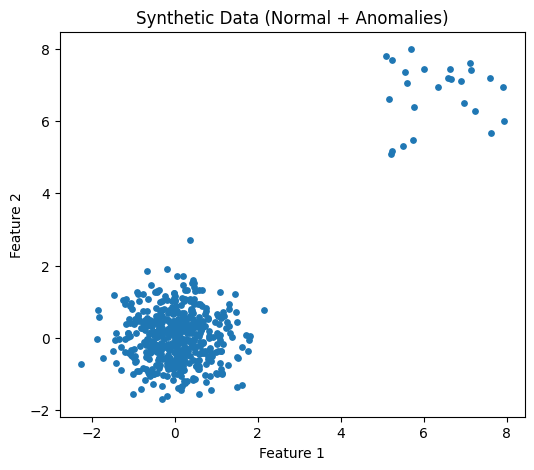

In [5]:
plt.scatter(X[:, 0], X[:, 1], s=15)
plt.title("Synthetic Data (Normal + Anomalies)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


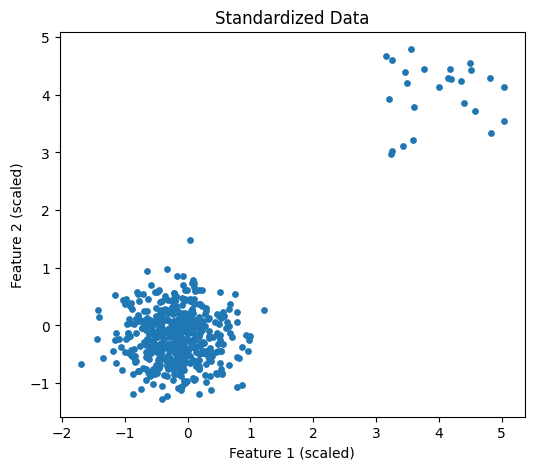

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=15)
plt.title("Standardized Data")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


In [7]:
# contamination ~ expected fraction of anomalies
contamination = n_anom / (n_normal + n_anom)
print("Contamination ratio:", contamination)

clf = IForest(
    contamination=contamination,
    random_state=42
)

clf.fit(X_scaled)

# PyOD uses:
#   0 = normal, 1 = outlier
y_pred = clf.predict(X_scaled)            # hard labels
scores = clf.decision_scores_            # raw anomaly scores

print("Model fitted.")


Contamination ratio: 0.047619047619047616
Model fitted.


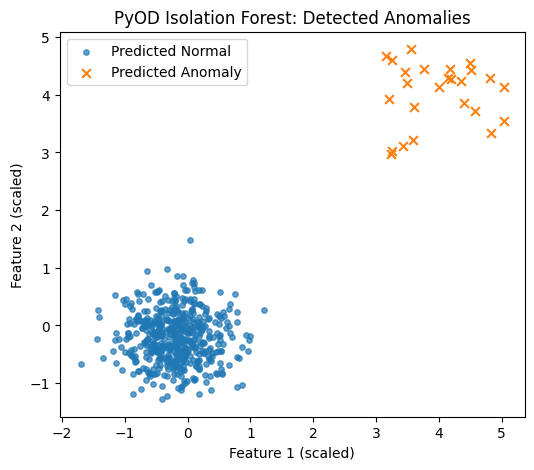

In [8]:
# Separate predicted normal and anomalies
mask_normal = y_pred == 0
mask_anom = y_pred == 1

plt.scatter(X_scaled[mask_normal, 0], X_scaled[mask_normal, 1],
            s=15, label="Predicted Normal", alpha=0.7)
plt.scatter(X_scaled[mask_anom, 0], X_scaled[mask_anom, 1],
            s=40, label="Predicted Anomaly", marker="x")
plt.title("PyOD Isolation Forest: Detected Anomalies")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()


In [9]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

# For ROC-AUC, we can use scores (higher = more anomalous)
auc = roc_auc_score(y_true, scores)
print("ROC AUC:", auc)


Confusion Matrix:
[[500   0]
 [  0  25]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       500
     Anomaly       1.00      1.00      1.00        25

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525

ROC AUC: 1.0


In [10]:
# Get indices of top 10 most anomalous points
top_idx = np.argsort(-scores)[:10]
print("Top 10 most anomalous indices:", top_idx)
print("Their true labels:", y_true[top_idx])


Top 10 most anomalous indices: [514 513 519 502 521 518 507 524 511 512]
Their true labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Conclusions

- I created a **2D synthetic dataset** with:
  - 500 normal points from a Gaussian distribution
  - 25 injected anomalies far from the cluster
- I used **PyOD** and the **Isolation Forest (IForest)** model for anomaly detection.
- PyOD returned:
  - Hard labels (0 = normal, 1 = anomaly)
  - Anomaly scores (higher = more anomalous)
- I visualized the predicted anomalies in feature space.
- I evaluated model performance using:
  - Confusion matrix
  - Classification report (precision, recall, F1-score)
  - ROC AUC score

This demonstrates **multivariate anomaly detection** using PyOD for the CMPE 255 assignment (Part e).
